<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%BB%B4%ED%93%A8%ED%84%B0_%EB%B9%84%EC%A0%84_%ED%95%99%EC%8A%B5_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

컴퓨터 비전 학습 경진대회  https://dacon.io/competitions/official/235626/overview/description

# module

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

# data load

In [135]:
train = pd.read_csv('/content/train.csv', index_col = 0).values
test = pd.read_csv('/content/train.csv', index_col = 0).values

In [48]:
train

array([[5, 'L', 1, ..., 4, 3, 4],
       [0, 'B', 0, ..., 2, 1, 2],
       [4, 'L', 1, ..., 0, 2, 2],
       ...,
       [9, 'A', 4, ..., 2, 0, 0],
       [0, 'Z', 2, ..., 4, 3, 1],
       [5, 'Z', 4, ..., 4, 3, 4]], dtype=object)

In [139]:
def get_tr_data(seed=42):
    train = pd.read_csv('/content/train.csv', index_col = 0).values
    train = shuffle(train, random_state=seed)
    x_train_ten = tf.convert_to_tensor(train[:,2:], dtype=tf.float32)
    y_train_ten = tf.convert_to_tensor(train[:,0], dtype=tf.int32)
    return x_train_ten, y_train_ten

x_train, y_train = get_tr_data()

In [60]:
x_test = tf.convert_to_tensor(test[:,2:], dtype=tf.float32)
x_test

<tf.Tensor: shape=(2048, 784), dtype=float32, numpy=
array([[1., 1., 1., ..., 4., 3., 4.],
       [0., 4., 0., ..., 2., 1., 2.],
       [1., 1., 2., ..., 0., 2., 2.],
       ...,
       [4., 0., 4., ..., 2., 0., 0.],
       [2., 3., 3., ..., 4., 3., 1.],
       [4., 2., 2., ..., 4., 3., 4.]], dtype=float32)>

In [72]:
image_size = (28,28)
image_size_re = (256,256)

@tf.function
def tr_rr(x_train, y_train):
    re_image = tf.reshape(x_train,(*image_size,1))
    re_image = tf.keras.layers.experimental.preprocessing.Resizing(*image_size_re)(re_image)
    re_image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(re_image)
    return re_image, y_train

@tf.function
def te_rr(x_test):
    re_image = tf.reshape(x_test,(*image_size,1))
    re_image = tf.keras.layers.experimental.preprocessing.Resizing(*image_size_re)(re_image)
    re_image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(re_image)
    return re_image

In [122]:
autotune = tf.data.experimental.AUTOTUNE
batch_size = 64

def print_shape(l, l_name, end=False):
    assert type(l) is list
    print(f'len({l_name}) = {len(l)}')
    for i in range(len(l)):
        print(f'{l_name}[{i}] : {l[i]}')
    if not end:
        print()

def make_dataset(x,y,type):
    if type == 'train':
        assert x.shape[0] == y.shape[0]
        dataset = tf.data.Dataset.from_tensor_slices((x,y)
        ).map(tr_rr, num_parallel_calls=autotune
        ).cache(
        ).shuffle(20000, reshuffle_each_iteration = True
        ).batch(batch_size
        ).prefetch(autotune)
    
    elif type == 'validation':
        assert x.shape[0] == y.shape[0]
        dataset = tf.data.Dataset.from_tensor_slices((x,y)
        ).map(tr_rr, num_parallel_calls=autotune
        ).cache(
        #).shuffle(20000, reshuffle_each_iteration = True
        ).batch(batch_size
        ).prefetch(autotune)
    
    elif type == 'test':
        assert y is None
        dataset = tf.data.Dataset.from_tensor_slices((x)
        ).map(tr_rr, num_parallel_calls=autotune
        ).cache(
        #).shuffle(20000, reshuffle_each_iteration = True
        ).batch(batch_size
        ).prefetch(autotune)
    else:
        raise ValueError(f'unknown type : {type}')
    
    return dataset

In [165]:
def make_fold(x, y, k=5):
    assert x.shape[0] == y.shape[0]
    assert len(list(y.shape)) == 1
    fold_size = [x.shape[0] // k] * (k-1) + [x.shape[0] - (x.shape[0] // k)*(k-1)]
    x_splited = tf.split(x, fold_size,0)
    y_splited = tf.split(y, fold_size,0)

    tr_list = [(tf.concat(x_splited[:i] + x_splited[i+1:], axis = 0), tf.concat(y_splited[:i] + y_splited[i+1:], axis = 0)) for i in range(k)]
    vl_list = [(x_splited[i], y_splited[i]) for i in range(k)]

    tr_datasets = [make_dataset(x_tr, y_tr,'train') for x_tr, y_tr in tr_list]
    vl_datasets = [make_dataset(x_vl, y_vl,'validation') for x_vl, y_vl in vl_list]
    
    return tr_datasets, vl_datasets

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


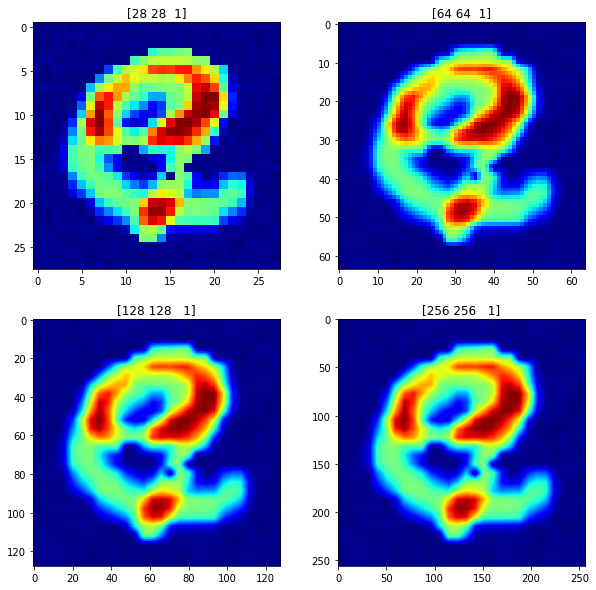

In [198]:
aa = x_train[1]
d = y_train[1]
aaa = tf.reshape(aa,(28,28,1))
aaa1 = tf.keras.layers.experimental.preprocessing.Resizing(64,64)(aaa)
aaa2 = tf.keras.layers.experimental.preprocessing.Resizing(128,128)(aaa)
aaa3 = tf.keras.layers.experimental.preprocessing.Resizing(256,256)(aaa)
aaaa = [aaa,aaa1,aaa2,aaa3]
plt.figure(figsize=(10,10))
for i,j in enumerate(aaaa):
    plt.subplot(2,2,i+1)
    plt.title(tf.shape(j).numpy())
    plt.imshow(tf.squeeze(j), cmap='jet')
plt.show()

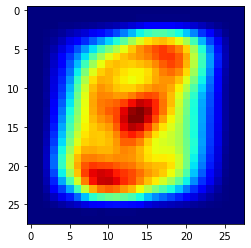

In [203]:
aa = tf.reshape(x_train, (-1, 28, 28, 1))
a = tf.math.reduce_sum(aa,axis=0)
plt.imshow(tf.squeeze(a),cmap='jet')

In [205]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [206]:
import tensorflow_addons as tfa

In [ ]:
tfa.optimizers.rectified_adam